In [1]:
import pandas as pd
import ast

from easynmt import EasyNMT
model = EasyNMT("opus-mt")

import networkx as nx
from networkx.algorithms.bipartite import biadjacency_matrix

import nxviz as nv
import matplotlib.pyplot as plt
from netgraph import Graph
import dataframe_image as dfi

from IPython.display import clear_output
clear_output()

In [11]:
def viz_table_articles(articles, folder_name_to="", to_en=False):
    articles_viz = articles[['url', 'title', 'seendate', 'domain', 'language']][:5]

    if not to_en:
        articles_viz['url'] = articles_viz['url'].str.slice(0,27) + "..."
        articles_viz['title'] = articles_viz['title'].str.slice(0,47) + "..."
        dfi.export(articles_viz.style.hide_index(), folder_name_to + "articles.png", table_conversion="matplotlib")
        return articles_viz.style.hide_index()
    else:
        articles_viz['title'] = articles_viz.apply(lambda row: model.translate(row['title'], target_lang="en"), axis=1)

        articles_viz['url'] = articles_viz['url'].str.slice(0,27) + "..."
        articles_viz['title'] = articles_viz['title'].str.slice(0,47) + "..."
        dfi.export(articles_viz.style.hide_index(), folder_name_to + "articles.png", table_conversion="matplotlib")
        return articles_viz.style.hide_index()

def viz_table_articles_with_keywords(articles_with_keywords, folder_name_to="", to_en=False):
    articles_with_keywords_viz = articles_with_keywords[['seendate', 'url', 'title', 'keywords']][:6]

    articles_with_keywords_viz = articles_with_keywords_viz.rename(columns = {'keywords': 'hashtags'})

    if not to_en:
        articles_with_keywords_viz['seendate'] = articles_with_keywords_viz['seendate'].str.slice(0,10)
        articles_with_keywords_viz['url'] = articles_with_keywords_viz['url'].str.slice(0,19) + "..."
        articles_with_keywords_viz['title'] = articles_with_keywords_viz['title'].str.slice(0,40) + "..."
        dfi.export(articles_with_keywords_viz.style.hide_index(), folder_name_to + "articles_with_keywords.png", table_conversion="matplotlib")
        return articles_with_keywords_viz.style.hide_index()
    else:
        articles_with_keywords_viz['title'] = articles_with_keywords_viz.apply(lambda row: model.translate(row['title'], target_lang="en"), axis=1)
        for index, row in articles_with_keywords_viz.iterrows():
            row["hashtags"] = ast.literal_eval(row["hashtags"])
            en_list = []
            for el in row["hashtags"]:
                en_list.append(model.translate(el, target_lang="en"))
            row["hashtags"] = en_list

        articles_with_keywords_viz['seendate'] = articles_with_keywords_viz['seendate'].str.slice(0,10)
        articles_with_keywords_viz['url'] = articles_with_keywords_viz['url'].str.slice(0,19) + "..."
        articles_with_keywords_viz['title'] = articles_with_keywords_viz['title'].str.slice(0,40) + "..."
        dfi.export(articles_with_keywords_viz.style.hide_index(), folder_name_to + "articles_with_keywords.png", table_conversion="matplotlib")
        return articles_with_keywords_viz.style.hide_index()


def viz_table_bipartite_connections(bipartite_connections, folder_name_to="", to_en=False):
    bipartite_connections_viz = bipartite_connections[['index', 'keywords']][:7]
    bipartite_connections_viz = bipartite_connections_viz.rename(columns = {'index': 'news'})
    bipartite_connections_viz = bipartite_connections_viz.rename(columns = {'keywords': 'hashtags'})

    if not to_en:        
        #add row to end of DataFrame
        bipartite_connections_viz.loc[len(bipartite_connections_viz.index)] = ["...", "..."]
        dfi.export(bipartite_connections_viz.style.hide_index(), folder_name_to + "bipartite_connections_table.png", table_conversion="matplotlib")
        return bipartite_connections_viz.style.hide_index()
    else:
        bipartite_connections_viz['hashtags'] = bipartite_connections_viz.apply(lambda row: model.translate(row['hashtags'], target_lang="en"), axis=1)

        #add row to end of DataFrame
        bipartite_connections_viz.loc[len(bipartite_connections_viz.index)] = ["...", "..."]
        dfi.export(bipartite_connections_viz.style.hide_index(), folder_name_to + "bipartite_connections_table.png", table_conversion="matplotlib")
        return bipartite_connections_viz.style.hide_index()


def viz_chart_bipartite_connections(df, n_rows=10, folder_name_to="", to_en=False):
    edges = df[["index", "keywords"]][:n_rows]

    if not to_en:
        edges = edges.to_numpy()
        Graph(
            edges,
            node_layout="bipartite",
            node_size=0.5,
            node_labels=True,
            node_label_offset=0.1,
            edge_width=0.1,
        )        
        plt.savefig(folder_name_to + 'bipartite_connections_chart.png')
        plt.show()
    else:
        edges['keywords'] = edges.apply(lambda row: model.translate(row['keywords'], target_lang="en"), axis=1)

        edges = edges.to_numpy()
        Graph(
            edges,
            node_layout="bipartite",
            node_size=0.5,
            node_labels=True,
            node_label_offset=0.1,
            edge_width=0.1,
        )
        plt.savefig(folder_name_to + 'bipartite_connections_chart.png')
        plt.show()


def get_top_keywords(df, n_words=10):
    return df['keywords'].value_counts()[:n_words]


def viz_table_top_keywords(bipartite_connections, n_words=15, folder_name_to="", to_en=False):
    top_keywords_viz = pd.DataFrame(get_top_keywords(bipartite_connections, n_words))
    top_keywords_viz.insert(0, 'index', top_keywords_viz.index.tolist())

    top_keywords_viz.columns = ['keywords', 'counts']

    top_keywords_viz = top_keywords_viz.rename(columns = {'keywords': 'hashtags'})

    top_keywords_viz = top_keywords_viz.reset_index(drop=True)

    if not to_en:
        # plot = top_keywords_viz.style.set_properties(subset=['hashtags'], **{'text-align': 'left'})
        dfi.export(top_keywords_viz.style.hide_index(), folder_name_to + "top_keywords.png", table_conversion="matplotlib")
        return top_keywords_viz.style.hide_index()
    else:
        top_keywords_viz['hashtags'] = top_keywords_viz.apply(lambda row: model.translate(row['hashtags'], target_lang="en"), axis=1)

        dfi.export(top_keywords_viz.style.hide_index(), folder_name_to + "top_keywords.png", table_conversion="matplotlib")
        return top_keywords_viz.style.hide_index()


def viz_table_incidence_matrix(incidence_matrix, folder_name_to="",):
    incidence_matrix_viz = pd.read_csv("/work/incidence_matrix.csv").iloc[:7,1:8]
    dfi.export(incidence_matrix_viz.style, folder_name_to + "incidence_matrix.png", table_conversion="matplotlib")
    return incidence_matrix_viz.style


def viz_nx_bipartite_connections(B):
    fig, ax = plt.subplots(figsize=(7, 7))
    nv.circos(B, group_by="bipartite", node_color_by="bipartite")

In [12]:
# generate all images
def viz_all(folder_name_from, folder_name_to="", en=False):
    articles = pd.read_csv("/work/" + folder_name_from + "/articles.csv")
    viz_table_articles(articles, folder_name_to, to_en=en)

    articles_with_keywords = pd.read_csv("/work/" + folder_name_from + "/articles_with_keywords.csv")
    viz_table_articles_with_keywords(articles_with_keywords, folder_name_to, to_en=en)

    bipartite_connections = pd.read_csv("/work/" + folder_name_from + "/bipartite_connections.csv")
    viz_table_bipartite_connections(bipartite_connections, folder_name_to, to_en=en)
    viz_chart_bipartite_connections(bipartite_connections, n_rows=15, folder_name_to=folder_name_to, to_en=en)
    viz_table_top_keywords(bipartite_connections, folder_name_to=folder_name_to, to_en=en)

    clear_output(wait=True)


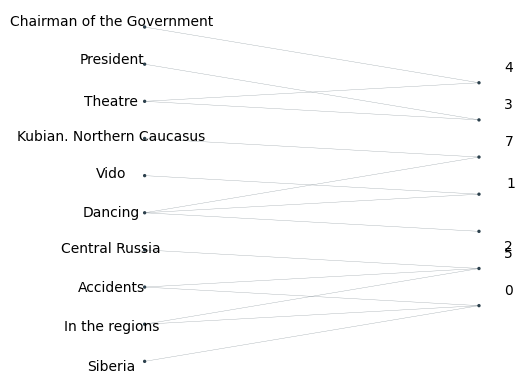

In [13]:
# viz_all(folder_name_from="rg_2022", folder_name_to="rg_2022/img_ru/", en=False)
viz_all(folder_name_from="rg_2022", folder_name_to="rg_2022/img_en/", en=True)

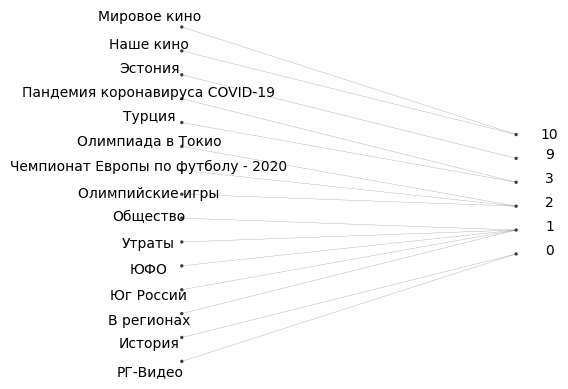

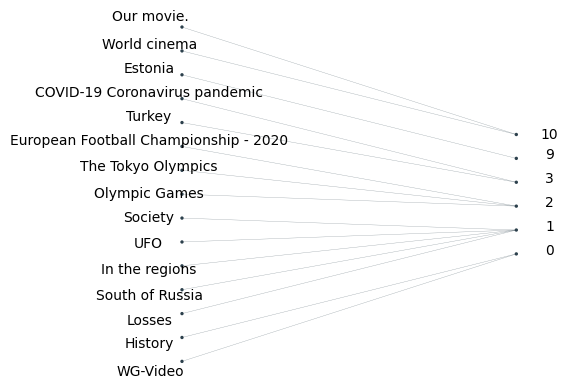

In [49]:
viz_all(folder_name_from="rg_2021", folder_name_to="rg_2021/img_ru/", en=False)
viz_all(folder_name_from="rg_2021", folder_name_to="rg_2021/img_en/", en=True)

In [4]:
# viz_all(folder_name_from="rbc_2022", folder_name_to="rbc_2022/img_ru/", en=False)
viz_all(folder_name_from="rbc_2022", folder_name_to="rbc_2022/img_en/", en=True)

/root/venv/lib/python3.9/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/root/venv/lib/python3.9/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Exception: Helsinki-NLP/opus-mt-tt-en is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.


OSError: Helsinki-NLP/opus-mt-tt-en is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

### Load data 

In [47]:
folder_name = "rg_2022"

articles = pd.read_csv("/work/" + folder_name + "/articles.csv")
articles_with_keywords = pd.read_csv("/work/" + folder_name + "/articles_with_keywords.csv")
bipartite_connections = pd.read_csv("/work/" + folder_name + "/bipartite_connections.csv")

### Articles 

In [31]:
viz_table_articles(articles)

url,title,seendate,domain,language
https://rg.ru/2022/01/01/re...,Алтаец сорвался со скалы в Катунь во время запу...,20220101T151500Z,rg.ru,Russian
https://rg.ru/2022/01/01/on...,Он разрушал пластиковую красоту балетной условн...,20220101T094500Z,rg.ru,Russian
https://rg.ru/2022/01/01/pr...,Прыжок Ивана Грозного : Как Юрий Владимиров изм...,20220101T134500Z,rg.ru,Russian
https://rg.ru/2022/01/02/pu...,Путин назвал Григоровича патриархом российской ...,20220102T111500Z,rg.ru,Russian
https://rg.ru/2022/01/02/mi...,Мишустин поздравил Григоровича с 95 - летием...,20220102T103000Z,rg.ru,Russian


In [16]:
viz_table_articles(articles, to_en=True)

,url,title,seendate,domain,language
0,https://rg.ru/2022/01/01/re...,Altac fell off a cliff in Katun during the fire...,20220101T151500Z,rg.ru,Russian
1,https://rg.ru/2022/01/01/on...,He was destroying the plastic beauty of ballet ...,20220101T094500Z,rg.ru,Russian
2,https://rg.ru/2022/01/01/pr...,Jumping Ivan Grozny : How Yuri Vladimirov chang...,20220101T134500Z,rg.ru,Russian
3,https://rg.ru/2022/01/02/pu...,Putin called Grigorovich the Patriarch of Russi...,20220102T111500Z,rg.ru,Russian
4,https://rg.ru/2022/01/02/mi...,Mishustin congratulated Grigorovich on his 95th...,20220102T103000Z,rg.ru,Russian


### Articles with keywords

In [32]:
viz_table_articles_with_keywords(articles_with_keywords)

seendate,url,title,keywords
2022-01-01,https://rg.ru/2022/...,Алтаец сорвался со скалы в Катунь во вре...,"['Несчастные случаи', 'Барнаул', 'Сибирь', 'В регионах']"
2022-01-01,https://rg.ru/2022/...,Он разрушал пластиковую красоту балетной...,"['Танец', 'РГ-Видео']"
2022-01-01,https://rg.ru/2022/...,Прыжок Ивана Грозного : Как Юрий Владими...,['Танец']
2022-01-02,https://rg.ru/2022/...,Путин назвал Григоровича патриархом росс...,"['Театр', 'Президент']"
2022-01-02,https://rg.ru/2022/...,Мишустин поздравил Григоровича с 95 - ле...,"['Театр', 'Председатель Правительства']"
2022-01-02,https://rg.ru/2022/...,Водитель разбившегося под Рязанью автобу...,"['ДТП', 'Рязанская область', 'Центральная Россия', 'В регионах']"


In [25]:
viz_table_articles_with_keywords(articles_with_keywords, to_en=True)

/root/venv/lib/python3.9/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


,seendate,url,title,keywords
0,2022-01-01,https://rg.ru/2022/...,Altac fell off a cliff in Katun during t...,"['Accidents', 'Barnaul', 'Siberia', 'In the regions']"
1,2022-01-01,https://rg.ru/2022/...,He was destroying the plastic beauty of ...,"['Dancing', 'WG-Video']"
2,2022-01-01,https://rg.ru/2022/...,Jumping Ivan Grozny : How Yuri Vladimiro...,['Dancing']
3,2022-01-02,https://rg.ru/2022/...,Putin called Grigorovich the Patriarch o...,"['Theatre', 'President']"
4,2022-01-02,https://rg.ru/2022/...,Mishustin congratulated Grigorovich on h...,"['Theatre', 'Chairman of the Government']"
5,2022-01-02,https://rg.ru/2022/...,The driver of the bus crashed under Riza...,"['Accidents', 'Ryazan Region', 'Central Russia', 'In the regions']"


### Bipartite connections table

In [30]:
viz_table_bipartite_connections(bipartite_connections)

news,keywords
0,Несчастные случаи
0,Сибирь
0,В регионах
1,Танец
1,РГ-Видео
2,Танец
3,Театр
...,...


In [34]:
viz_table_bipartite_connections(bipartite_connections, to_en=True)

/root/venv/lib/python3.9/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


news,keywords
0,Accidents
0,Siberia
0,In the regions
1,Dancing
1,WG-Video
2,Dancing
3,Theatre
...,...


### Bipartite connections chart

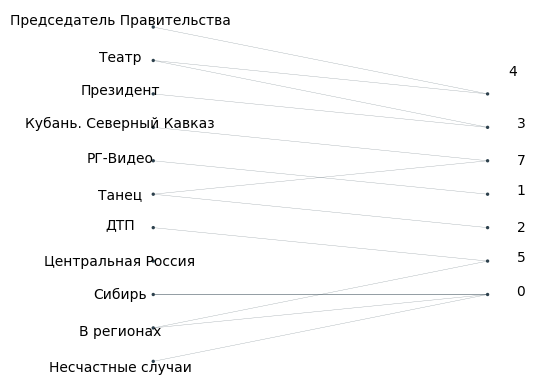

In [49]:
viz_chart_bipartite_connections(bipartite_connections, 15)

/root/venv/lib/python3.9/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/netgraph/_node_layout.py:1157: UserWarning: The graph consistst of multiple components, and hence the partitioning into two subsets/layers is ambiguous!
Use the `subsets` argument to explicitly specify the desired partitioning.
  warnings.warn(msg)


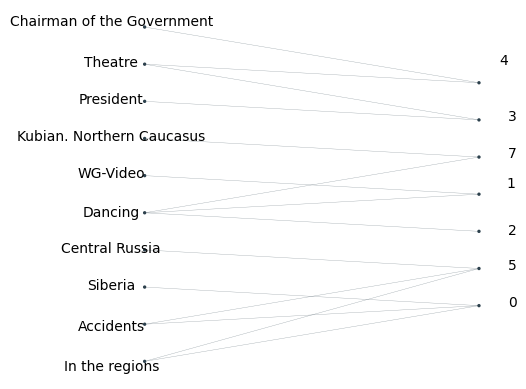

In [39]:
viz_chart_bipartite_connections(bipartite_connections, 15, to_en=True)

### Top keywords

In [64]:
viz_table_top_keywords(bipartite_connections)

keywords,counts
В регионах,249
История,117
Внешняя политика,75
Украина,59
Литература,59
РГ-Фото,56
США,52
Гид-парк,50
РГ-Видео,49
Специальная военная операция по защите ДНР и ЛНР,49


In [65]:
viz_table_top_keywords(bipartite_connections, to_en=True)

/root/venv/lib/python3.9/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


keywords,counts
In the regions,249
History,117
Foreign policy,75
Ukraine,59
References,59
RG-Foto,56
(Thousands of United States dollars),52
Hyd Park,50
WG-Video,49
Special military operation for the protection of DNR and LND,49


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0d79deab-c9c6-414b-8803-1e385542ff1f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>